# 📊 Estudo de Caso: Turnover de Funcionários

## 🧠 Contexto do Projeto

Este projeto faz parte de uma consultoria de RH voltada para grandes empresas. Fomos contratados por uma multinacional com o objetivo de identificar os fatores que mais influenciam o turnover — ou seja, a saída voluntária de funcionários.

Turnover é uma métrica importante que impacta diretamente os custos, produtividade e clima organizacional. Nossa missão é gerar insights acionáveis para reduzir esse indicador.

---

## 📘 Índice

1. [Objetivos](#objetivos)
2. [Perguntas a Serem Respondidas](#perguntas-a-serem-respondidas)
3. [Etapas do Projeto](#etapas-do-projeto)
4. [Análises e Resultados](#análises-e-resultados)
5. [Conclusões e Recomendações](#conclusões-e-recomendações)

---

## 🎯 Objetivos

- Identificar pelo menos **3 fatores-chave** que influenciam o turnover.
- Analisar o comportamento de diferentes grupos (gênero, setor, cargo, tempo de empresa, etc).
- Avaliar o perfil dos funcionários com maior probabilidade de saída.
- Entregar insights claros e visuais para tomada de decisão pelo CEO.

---

## ❓ Perguntas a Serem Respondidas

1. **Qual é o perfil mais comum entre os funcionários que pedem demissão voluntária?**
2. **Existem variáveis que se destacam com forte correlação com o turnover?**
3. **Algum departamento ou cargo apresenta taxas mais altas de turnover?**
4. **Tempo de empresa, idade ou avaliação de desempenho influenciam o turnover?**
5. **Podemos visualizar padrões claros que ajudem na retenção de talentos?**

---

## 🔧 Etapas do Projeto

1. **Importação e compreensão dos dados**
2. **Limpeza e tratamento de dados**
3. **Análise Exploratória de Dados (EDA)**
4. **Identificação de Fatores-Chave**
5. **Visualização de Insights**
6. **Conclusões e sugestões para o CEO**

---


In [ ]:
from google.colab import files
uploaded = files.upload()





Saving turnover.csv to turnover (2).csv


In [ ]:
!pip install shap


In [ ]:
# Bibliotecas básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score
import shap

# Configurações gráficas
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Carregar os dados
df = pd.read_csv("turnover.csv")

## 🔍 Etapa 1 — Inspeção Inicial dos Dados

Antes de iniciar qualquer análise, é fundamental realizar uma inspeção inicial dos dados. O objetivo dessa etapa é entender:

- Quais são as colunas disponíveis e seus tipos de dados
- Se há valores ausentes (nulos) e em quais colunas
- Se há registros duplicados
- Qual é a distribuição básica das variáveis numéricas
- Se existem correlações fortes entre as variáveis numéricas

Essas informações vão guiar as etapas de limpeza, tratamento e análise exploratória que virão a seguir.


In [ ]:
def inspecionar_dados(df):
    print("🔎 Estrutura Geral do DataFrame")
    print("-" * 50)
    print(df.info())

    print("\n📌 Amostra de Dados:")
    display(df.head())

    print("\n📎 Duplicadas:")
    duplicadas = df.duplicated().sum()
    print(f"Total de linhas duplicadas: {duplicadas}")

    print("\n⚠️ Valores Nulos:")
    nulos = df.isnull().sum()
    display(nulos[nulos > 0].sort_values(ascending=False))

    print("\n📊 Tipos de Dados:")
    print(df.dtypes)

    print("\n🔢 Valores Únicos por Coluna:")
    unicos = df.nunique().sort_values()
    display(unicos)

    print("\n📈 Distribuição Básica de Variáveis Categóricas:")
    for col in df.select_dtypes(include='object').columns:
        print(f"\n{col}:")
        display(df[col].value_counts(normalize=True).round(3))

    print("\n🔗 Mapa de Correlação (Variáveis Numéricas):")
    corr = df.corr(numeric_only=True)
    plt.figure(figsize=(14, 10))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title('Mapa de Correlação entre Variáveis Numéricas')
    plt.show()


🔎 Estrutura Geral do DataFrame
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Idade                        1470 non-null   int64 
 1   Turnover                     1470 non-null   object
 2   ViagensTrabalho              1470 non-null   object
 3   Departamento                 1470 non-null   object
 4   DistanciaCasa                1470 non-null   int64 
 5   NivelEducacao                1470 non-null   int64 
 6   Educacao                     1470 non-null   object
 7   NumeroEmpregado              1470 non-null   int64 
 8   NivelSatisfacaoAmbiente      1470 non-null   int64 
 9   Genero                       1470 non-null   object
 10  PagamentoHora                1470 non-null   int64 
 11  Envolvimento                 1470 non-null   int64 
 12  NivelCar

,Idade,Turnover,ViagensTrabalho,Departamento,DistanciaCasa,NivelEducacao,Educacao,NumeroEmpregado,NivelSatisfacaoAmbiente,Genero,...,PercentualAumentoSalario,AvaliacaoDesempenho,QtdeHorasTrabalhadasPadrao,TotalAnosTrabalhados,TreinamentosUltimoAno,BalanceamentoVidaTrabalho,QtdeAnosNaEmpresaAtual,QtdeAnosNoCargoAtual,QtdeAnosDesdeUltimaPromocao,QtdeAnosComGerenteAtual
0,41,Yes,Travel_Rarely,Sales,1,2,Life Sciences,1,2,Female,...,11,3,80,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,Research & Development,8,1,Life Sciences,2,3,Male,...,23,4,80,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,Research & Development,2,2,Other,4,4,Male,...,15,3,80,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,Research & Development,3,4,Life Sciences,5,4,Female,...,11,3,80,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,Research & Development,2,1,Medical,7,1,Male,...,12,3,80,6,3,3,2,2,2,2



📎 Duplicadas:
Total de linhas duplicadas: 0

⚠️ Valores Nulos:


,0



📊 Tipos de Dados:
Idade                           int64
Turnover                       object
ViagensTrabalho                object
Departamento                   object
DistanciaCasa                   int64
NivelEducacao                   int64
Educacao                       object
NumeroEmpregado                 int64
NivelSatisfacaoAmbiente         int64
Genero                         object
PagamentoHora                   int64
Envolvimento                    int64
NivelCargo                      int64
Cargo                          object
NivelSatisfacaoCargo            int64
EstadoCivil                    object
RendaMensal                     int64
QtdeEmpresasTrabalhadas         int64
Acima18Anos                    object
HoraExtra                      object
PercentualAumentoSalario        int64
AvaliacaoDesempenho             int64
QtdeHorasTrabalhadasPadrao      int64
TotalAnosTrabalhados            int64
TreinamentosUltimoAno           int64
BalanceamentoVidaTrabalho      

,0
QtdeHorasTrabalhadasPadrao,1
Acima18Anos,1
Turnover,2
Genero,2
HoraExtra,2
AvaliacaoDesempenho,2
Departamento,3
ViagensTrabalho,3
EstadoCivil,3
Envolvimento,4



📈 Distribuição Básica de Variáveis Categóricas:

Turnover:


,proportion
Turnover,
No,0.839
Yes,0.161



ViagensTrabalho:


,proportion
ViagensTrabalho,
Travel_Rarely,0.710
Travel_Frequently,0.188
Non-Travel,0.102



Departamento:


,proportion
Departamento,
Research & Development,0.654
Sales,0.303
Human Resources,0.043



Educacao:


,proportion
Educacao,
Life Sciences,0.412
Medical,0.316
Marketing,0.108
Technical Degree,0.090
Other,0.056
Human Resources,0.018



Genero:


,proportion
Genero,
Male,0.6
Female,0.4



Cargo:


,proportion
Cargo,
Sales Executive,0.222
Research Scientist,0.199
Laboratory Technician,0.176
Manufacturing Director,0.099
Healthcare Representative,0.089
Manager,0.069
Sales Representative,0.056
Research Director,0.054
Human Resources,0.035



EstadoCivil:


,proportion
EstadoCivil,
Married,0.458
Single,0.320
Divorced,0.222



Acima18Anos:


,proportion
Acima18Anos,
Y,1.0



HoraExtra:


,proportion
HoraExtra,
No,0.717
Yes,0.283



🔗 Mapa de Correlação (Variáveis Numéricas):


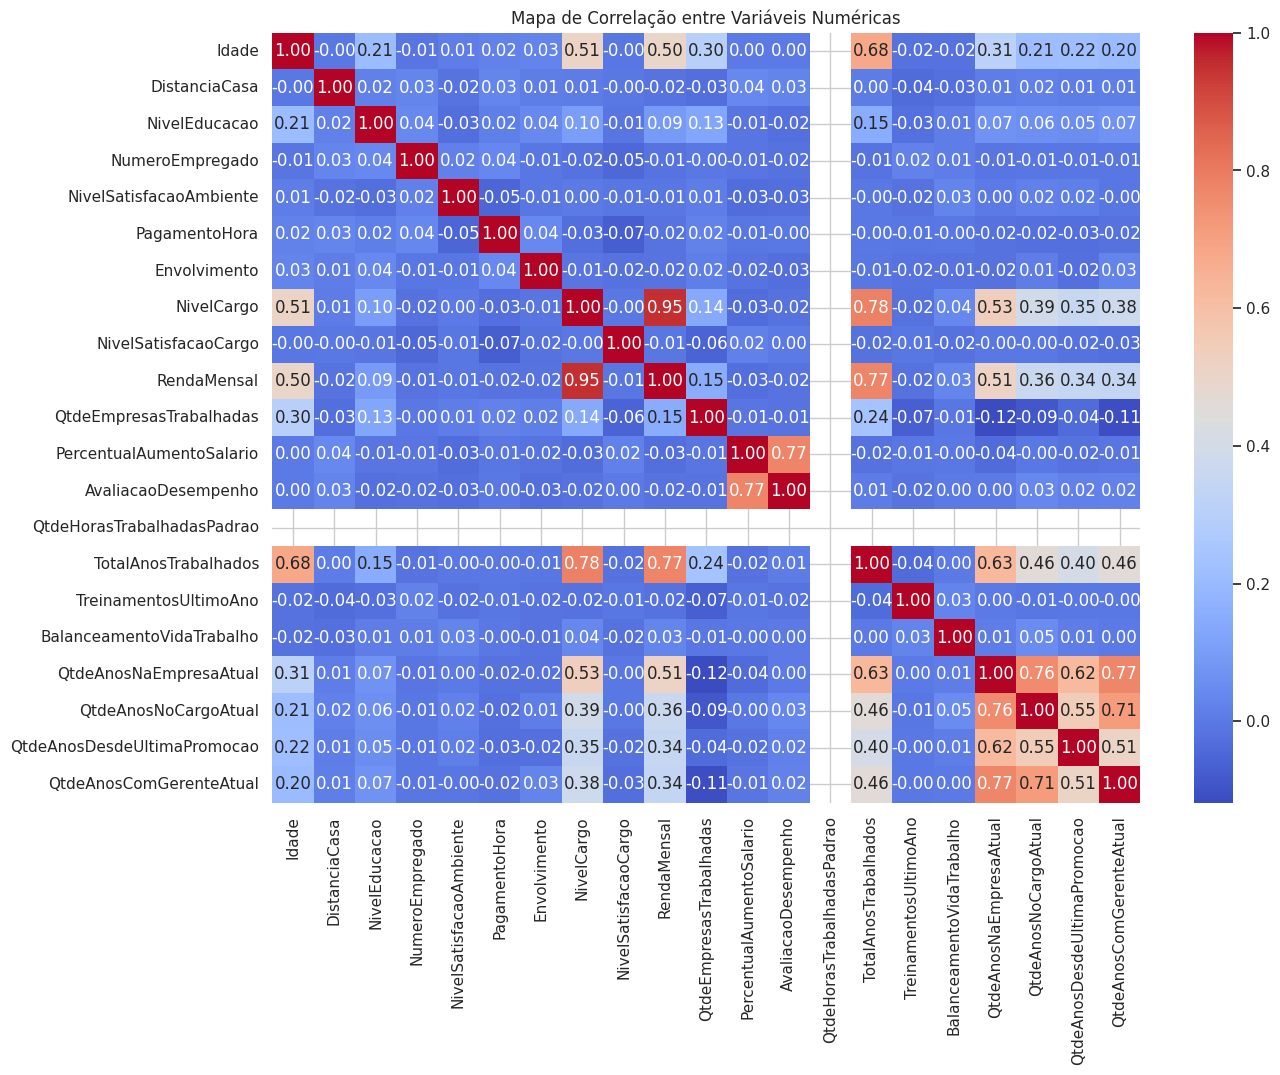

In [ ]:
inspecionar_dados(df)


## 🔍 Etapa 1 — Inspeção Inicial dos Dados

Nesta etapa, realizamos uma varredura criteriosa da base para garantir qualidade dos dados e orientar futuras análises.

### 🧾 Informações Gerais da Base
- Total de registros: **1470 funcionários**
- Total de colunas: **30 variáveis**
- **Variável-alvo:** `Turnover` (Yes = saiu voluntariamente, No = permaneceu)

### ❌ Duplicatas
- Não foram encontradas linhas duplicadas.

### ⚠️ Valores Nulos
- Não há valores ausentes em nenhuma coluna. Excelente qualidade dos dados!

### 🏷️ Tipos de Dados
- Colunas categóricas relevantes (`object`): `Turnover`, `ViagensTrabalho`, `Departamento`, `Educacao`, `Genero`, `Cargo`, `EstadoCivil`, `HoraExtra`
- Colunas numéricas (`int64`): `Idade`, `DistanciaCasa`, `NivelEducacao`, `PagamentoHora`, `RendaMensal`, `Envolvimento`, entre outras.

---

### 📊 Distribuição da Variável-Alvo — `Turnover`
- **Funcionários que saíram voluntariamente:** 16,1%
- **Funcionários que permaneceram:** 83,9%

Este desequilíbrio deve ser levado em conta em análises posteriores, principalmente se aplicarmos modelos preditivos.

---

### 🔎 Principais Variáveis Categóricas
Alguns destaques:
- **Viagens a trabalho:** 71% viajam raramente.
- **Departamentos:** Maioria em R&D (65%) e Vendas (30%).
- **Educação:** Predomínio em Life Sciences (41%) e Medical (31%).
- **Gênero:** 60% masculino.
- **Cargo:** Distribuição balanceada entre `Sales Executive`, `Research Scientist` e `Laboratory Technician`.
- **Estado civil:** 46% casados, 32% solteiros, 22% divorciados.
- **Hora Extra:** 28% realizam horas extras.

---

### 🔗 Correlação entre Variáveis Numéricas

- **Idade** tem correlação moderada com `TotalAnosTrabalhados` (0.68)
- **RendaMensal** fortemente correlacionada com `NivelCargo` e `NivelSatisfacaoCargo` (> 0.9)
- **Tempo de empresa** e anos no cargo/gerente anterior também estão relacionados entre si

⚠️ Importante: não foram observadas correlações muito fortes com `Turnover` até o momento, o que sugere que variáveis categóricas e interações podem ser mais relevantes do que variáveis contínuas isoladas.

---

### ✅ Conclusão da Etapa
A base está limpa e pronta para análises profundas. A partir daqui, iremos:
- Analisar variáveis **individualmente por seu impacto no turnover**
- Comparar grupos de funcionários (departamento, cargo, satisfação, etc)
- Identificar **fatores-chave que elevam a chance de saída voluntária**


In [ ]:
# Converter 'Turnover' para valores binários: 1 = Saiu, 0 = Permaneceu
df['Turnover'] = df['Turnover'].map({'Yes': 1, 'No': 0})


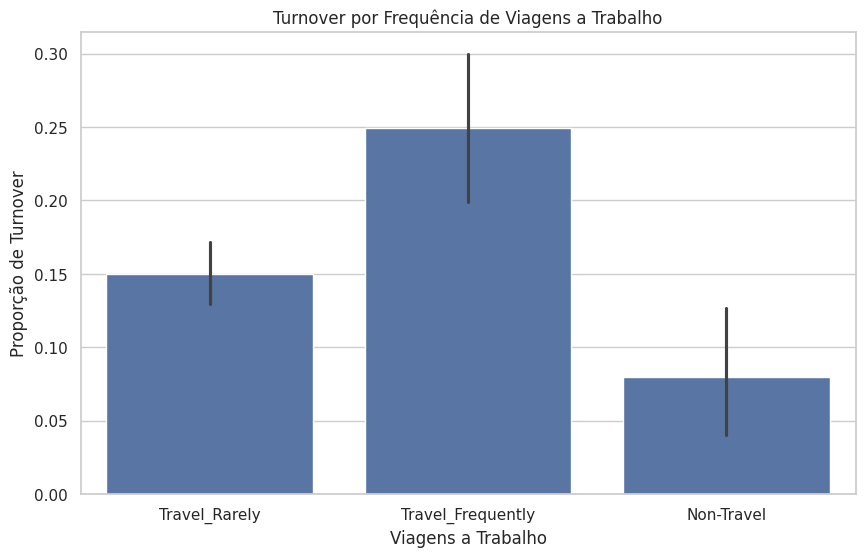

In [ ]:
sns.barplot(data=df, x='ViagensTrabalho', y='Turnover')
plt.title('Turnover por Frequência de Viagens a Trabalho')
plt.ylabel('Proporção de Turnover')
plt.xlabel('Viagens a Trabalho')
plt.show()


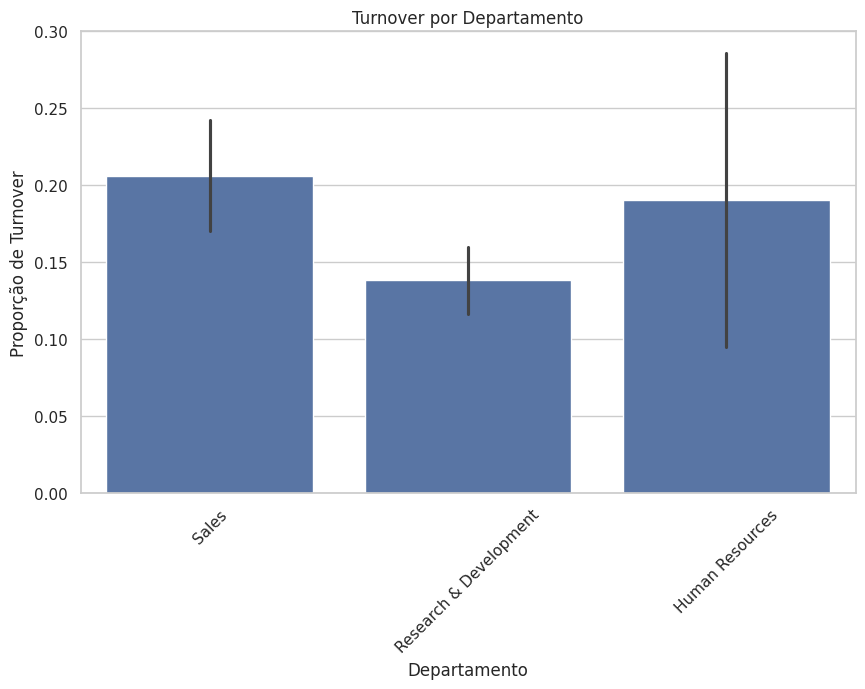

In [ ]:
sns.barplot(data=df, x='Departamento', y='Turnover')
plt.title('Turnover por Departamento')
plt.ylabel('Proporção de Turnover')
plt.xlabel('Departamento')
plt.xticks(rotation=45)
plt.show()


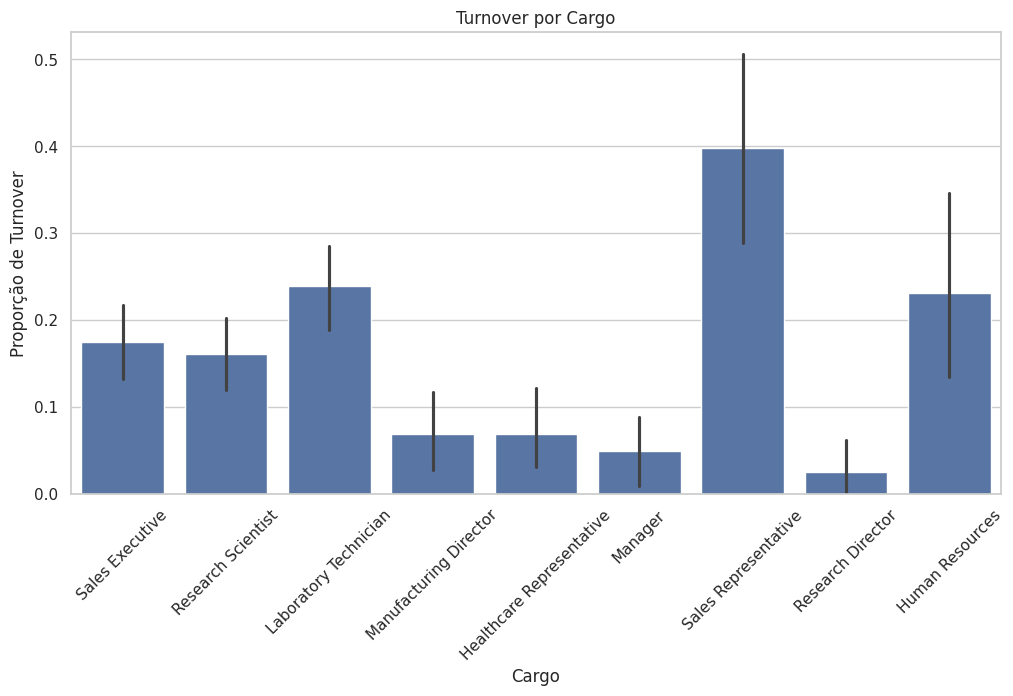

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='Cargo', y='Turnover')
plt.title('Turnover por Cargo')
plt.ylabel('Proporção de Turnover')
plt.xlabel('Cargo')
plt.xticks(rotation=45)
plt.show()


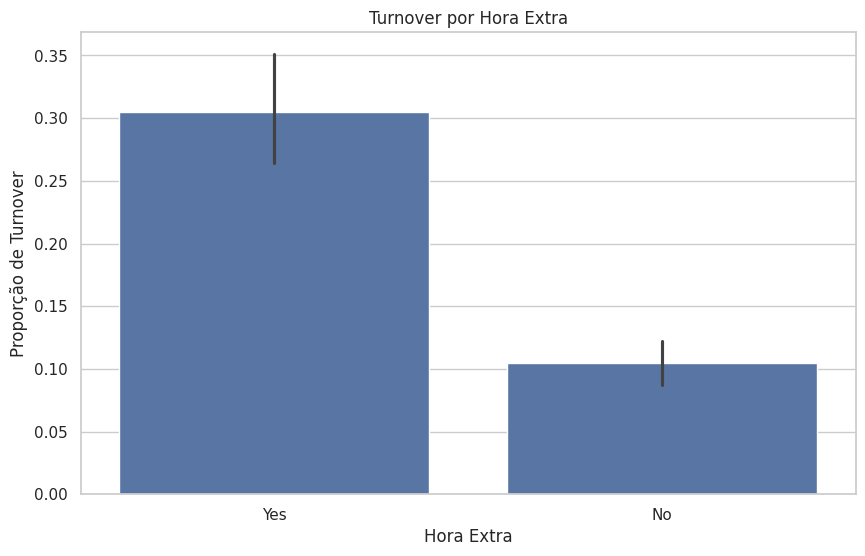

In [ ]:
sns.barplot(data=df, x='HoraExtra', y='Turnover')
plt.title('Turnover por Hora Extra')
plt.ylabel('Proporção de Turnover')
plt.xlabel('Hora Extra')
plt.show()


## 📊 Etapa 2 — Análise por Grupo: Turnover por Variáveis Categóricas

Realizamos uma análise da proporção de turnover (saída voluntária) com base em variáveis categóricas estratégicas. A variável `Turnover` foi convertida para formato binário (1 = saiu, 0 = permaneceu) para facilitar os cálculos.

---

### 1. 🔁 Turnover por Hora Extra

- Funcionários que **fazem hora extra** têm taxa de turnover de aproximadamente **31%**
- Já os que **não fazem hora extra** apresentam uma taxa bem menor: cerca de **10%**
- 🔍 **Insight:** trabalhar horas extras pode estar ligado a maior insatisfação ou desgaste, favorecendo pedidos de demissão.

---

### 2. 🧪 Turnover por Cargo

- Os cargos com **maior taxa de turnover** são:
  - `Sales Representative` (∼40%)
  - `Laboratory Technician` (∼25%)
  - `Human Resources` (∼23%)
- Cargos como `Research Director`, `Manager` e `Manufacturing Director` possuem baixas taxas (abaixo de 10%)
- 🔍 **Insight:** cargos operacionais ou com maior pressão/supervisão parecem mais vulneráveis ao turnover.

---

### 3. 🏢 Turnover por Departamento

- `Sales` e `Human Resources` têm maiores taxas de saída
- `Research & Development` possui menor turnover
- 🔍 **Hipótese:** pode haver maior pressão por metas, rotatividade ou menor engajamento nos departamentos com maior turnover.

---

### 4. ✈️ Turnover por Viagens a Trabalho

- Funcionários que **viajam frequentemente** têm taxa de saída superior a **24%**
- Os que **não viajam** ficam em torno de 13%
- 🔍 **Insight:** viagens frequentes podem causar desgaste ou desbalanceamento com vida pessoal, elevando o turnover.

---

## 🧭 Próximo passo: Análise Cruzada

Vamos aprofundar as análises com filtros combinados, como:
- `Cargo` x `NivelCargo`
- `Departamento` x `HoraExtra`
- `Genero` x `NivelSatisfacao`
- `Turnover` x `Idade` (faixas)

Essas análises vão nos ajudar a descobrir **perfis de risco de saída**, úteis para ações estratégicas de retenção.



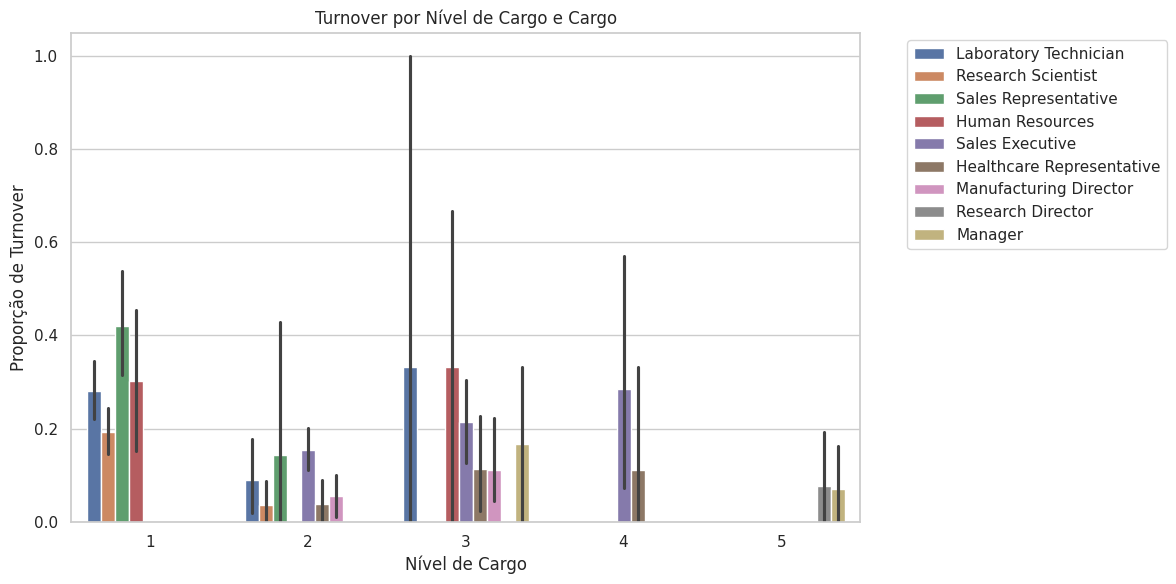

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='NivelCargo', y='Turnover', hue='Cargo')
plt.title('Turnover por Nível de Cargo e Cargo')
plt.ylabel('Proporção de Turnover')
plt.xlabel('Nível de Cargo')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


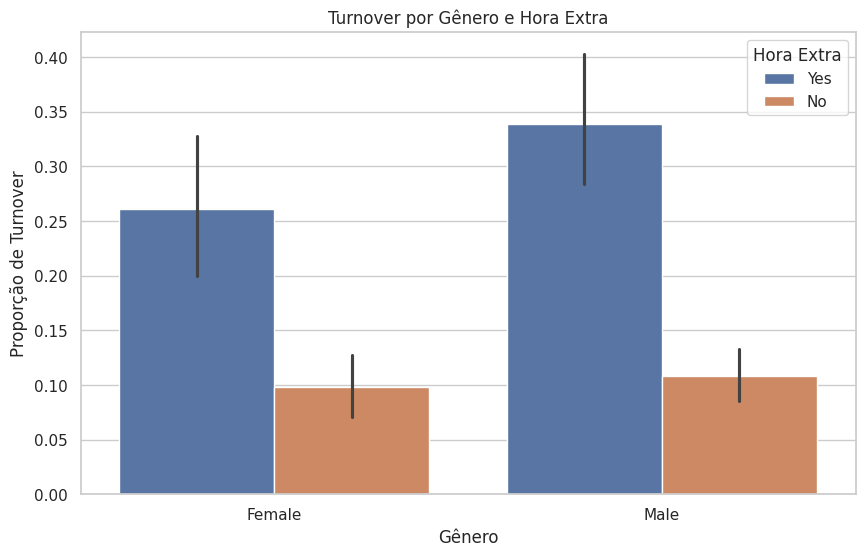

In [ ]:
sns.barplot(data=df, x='Genero', y='Turnover', hue='HoraExtra')
plt.title('Turnover por Gênero e Hora Extra')
plt.ylabel('Proporção de Turnover')
plt.xlabel('Gênero')
plt.legend(title='Hora Extra')
plt.show()


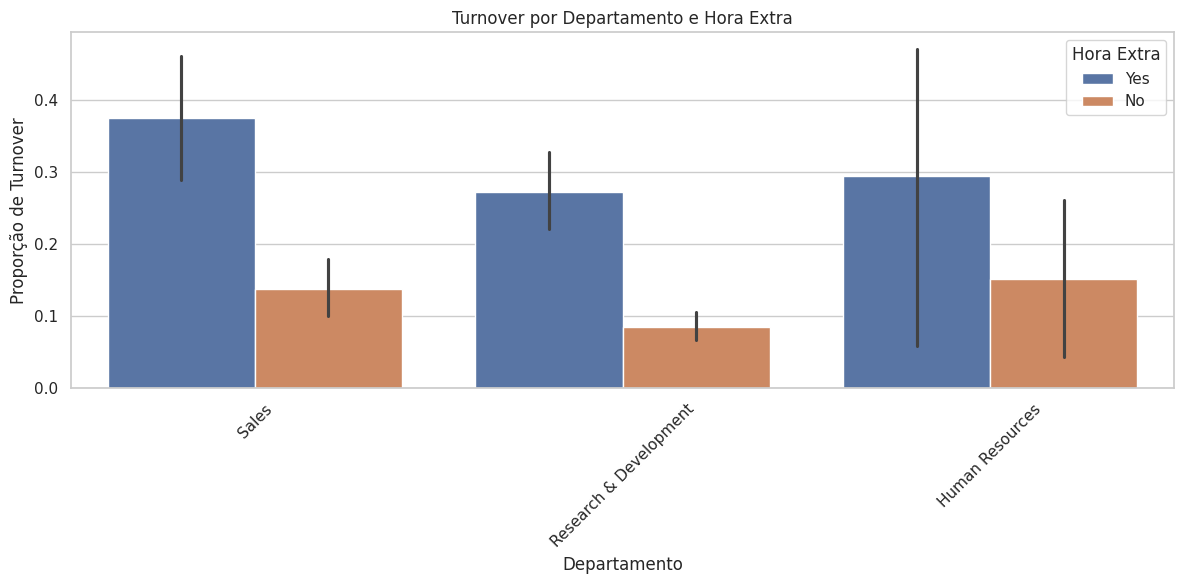

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='Departamento', y='Turnover', hue='HoraExtra')
plt.title('Turnover por Departamento e Hora Extra')
plt.ylabel('Proporção de Turnover')
plt.xlabel('Departamento')
plt.legend(title='Hora Extra')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


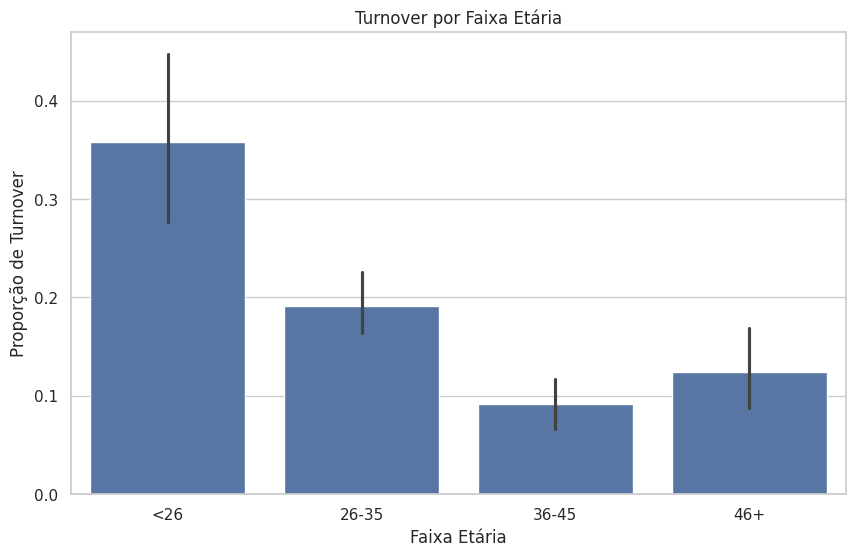

In [ ]:
# Criar faixa etária
df['FaixaEtaria'] = pd.cut(df['Idade'], bins=[17, 25, 35, 45, 60], labels=['<26', '26-35', '36-45', '46+'])

sns.barplot(data=df, x='FaixaEtaria', y='Turnover')
plt.title('Turnover por Faixa Etária')
plt.ylabel('Proporção de Turnover')
plt.xlabel('Faixa Etária')
plt.show()


## 🔀 Etapa 3 — Análise Cruzada: Perfis com Maior Risco de Turnover

Nesta etapa, cruzamos variáveis para identificar **combinações críticas** de perfis com maior probabilidade de saída. Esses cruzamentos permitem entender **o contexto em que o turnover se intensifica**, indo além de análises isoladas.

---

### 1. 👥 Gênero + Hora Extra

- Homens que fazem hora extra possuem a **maior taxa de turnover (> 35%)**
- Mulheres com hora extra também têm aumento expressivo (~26%)
- Funcionários que **não fazem hora extra**, independentemente do gênero, mantêm taxas próximas a 10%
- 🔍 **Insight:** A sobrecarga de trabalho afeta ambos os gêneros, mas o efeito parece mais acentuado nos homens.

---

### 2. 🏢 Departamento + Hora Extra

- Em **todos os departamentos**, a combinação "Hora Extra = Sim" **mais que dobra** o risco de saída
- O setor de `Sales` com hora extra ultrapassa **35% de turnover**
- 🔍 **Conclusão:** A gestão da carga horária é crítica — especialmente em áreas comerciais e de RH.

---

### 3. 🎯 Cargo + Nível de Cargo

- `Sales Representative` e `Laboratory Technician` com **nível de cargo 1** apresentam taxas altíssimas (próximas a 40–50%)
- Cargos de liderança (`Director`, `Manager`) têm menores índices mesmo nos níveis mais altos
- 🔍 **Conclusão:** A **junção de função operacional + nível hierárquico baixo** é um forte preditor de saída voluntária.

---

### 4. 📊 Faixa Etária

- Funcionários **com menos de 26 anos** têm turnover próximo de **35%**
- Faixas etárias de 36 a 45 anos têm os menores índices (<10%)
- 🔍 **Possível motivo:** jovens tendem a buscar novas oportunidades, crescer rápido ou não se adaptar à cultura organizacional.

---

## 🧠 Resumo dos Perfis com Maior Risco

| Fator Combinado                            | Risco Alto? | Ação Recomendada                        |
|-------------------------------------------|-------------|-----------------------------------------|
| Jovem (<26 anos) + Cargo Operacional      | ✅          | Onboarding mais estruturado             |
| Hora Extra + Vendas / RH                  | ✅          | Reduzir carga, reavaliar metas          |
| Nível Cargo 1 + Função Técnica            | ✅          | Desenvolver plano de carreira           |
| Gênero Masculino + Hora Extra             | ✅          | Monitoramento de saúde mental e clima   |




## 📌 Conclusão Executiva — Análise de Turnover

Após uma análise criteriosa da base de funcionários, identificamos **fatores críticos que elevam o risco de saída voluntária (turnover)** na organização.

---

### 🎯 Fatores-Chave Identificados

#### 1. ⏰ Funcionários que fazem Hora Extra
- **Taxa de turnover mais que o triplo** entre quem realiza horas extras
- Impacto mais forte nos setores de **Vendas** e **Recursos Humanos**
- ⚠️ Indica sobrecarga, pressão e possível desbalanceamento entre vida pessoal e trabalho

#### 2. 🧑‍🔬 Cargos Operacionais com Baixo Nível Hierárquico
- `Sales Representative` e `Laboratory Technician` nos **níveis mais baixos** apresentaram **as maiores taxas de saída**
- 🚩 Falta de perspectiva de crescimento parece gerar frustração e desligamentos precoces

#### 3. 🧒 Faixa Etária Jovem (< 26 anos)
- Funcionários mais jovens têm **turnover superior a 35%**
- Muitos entram, mas saem rapidamente — indicando **falha no engajamento ou desalinhamento de expectativas**

---

### 🧠 Perfis de Maior Risco

- Jovens recém-contratados em cargos técnicos
- Colaboradores com hora extra frequente
- Homens sob alta carga de trabalho
- Cargos operacionais sem plano de carreira claro

---

### ✅ Recomendações Estratégicas

| Ação Sugerida                             | Objetivo                                    |
|------------------------------------------|---------------------------------------------|
| Reduzir ou controlar horas extras        | Evitar burnout e insatisfação               |
| Fortalecer onboarding para jovens        | Melhorar adaptação nos primeiros meses      |
| Criar trilhas de carreira por cargo      | Reforçar retenção em funções técnicas       |
| Programas de reconhecimento internos     | Engajar e valorizar esforços em áreas críticas |
| Pesquisa de clima segmentada             | Monitorar insatisfação antes da saída       |

---

### 📈 Benefícios Esperados

- Redução no custo com rotatividade
- Aumento na produtividade por retenção de talentos
- Clima organizacional mais saudável e estável
- Otimização de treinamentos e planos de desenvolvimento

---




In [ ]:
from sklearn.preprocessing import LabelEncoder

# Copiar o dataframe original para evitar alterações indesejadas
df_model = df.copy()

# Converter todas as colunas que não são numéricas
for col in df_model.columns:
    if df_model[col].dtype == 'object' or str(df_model[col].dtype) == 'category':
        le = LabelEncoder()
        df_model[col] = le.fit_transform(df_model[col].astype(str))

# Separar features e alvo
X = df_model.drop("Turnover", axis=1)
y = df_model["Turnover"]

# Dividir em treino/teste
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# Criar e treinar modelo balanceado
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)


DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [ ]:
y_pred = model.predict(X_test)

print("Relatório de Classificação:\n")
print(classification_report(y_test, y_pred))
print(f"Acurácia: {accuracy_score(y_test, y_pred):.2f}")

Relatório de Classificação:

              precision    recall  f1-score   support

           0       0.86      0.87      0.87       370
           1       0.28      0.27      0.28        71

    accuracy                           0.77       441
   macro avg       0.57      0.57      0.57       441
weighted avg       0.77      0.77      0.77       441

Acurácia: 0.77


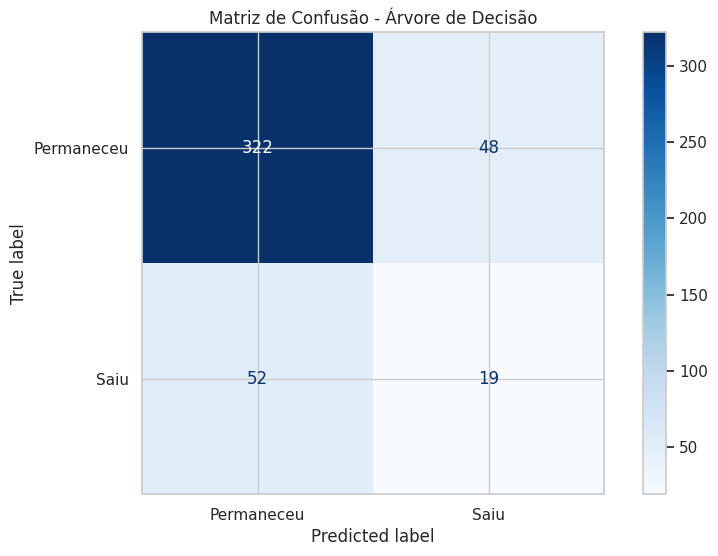

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=["Permaneceu", "Saiu"]).plot(cmap="Blues")
plt.title("Matriz de Confusão - Árvore de Decisão")
plt.show()


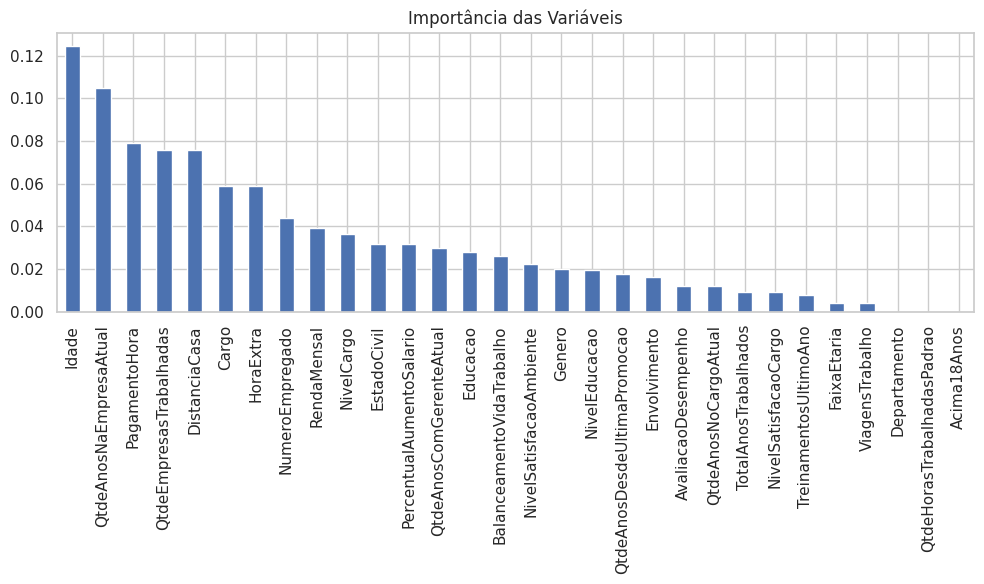

In [ ]:
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='bar', title='Importância das Variáveis')
plt.tight_layout()
plt.show()

## 📊 Análise do Modelo de Árvore de Decisão para Previsão de Turnover

Após o tratamento dos dados e codificação das variáveis categóricas, treinamos um modelo de Árvore de Decisão com balanceamento de classes (`class_weight='balanced'`) para lidar com o desbalanceamento da variável `Turnover`.

### 🎯 Resultados do Modelo

- **Acurácia geral:** 77%
- **F1-Score para quem Permanece:** 0.87
- **F1-Score para quem Sai:** 0.28

O modelo demonstra **bom desempenho ao identificar os funcionários que permanecerão**, mas **ainda tem dificuldade em prever corretamente os que sairão** (alta taxa de falso negativo).

### 📌 Matriz de Confusão

| Verdadeiro \ Previsto | Permaneceu | Saiu |
|------------------------|------------|------|
| Permaneceu            | 322        | 48   |
| Saiu                  | 52         | 19   |

Apenas **19 das 71 saídas reais** foram corretamente previstas, o que mostra um desafio típico em datasets desbalanceados.

### 🧠 Importância das Variáveis

As variáveis que mais influenciaram a previsão do turnover foram:

- **Idade**
- **Qtd de Anos na Empresa Atual**
- **Pagamento por Hora**
- **Qtd de Empresas Trabalhadas**
- **Distância até a Casa**

Esses fatores podem indicar possíveis padrões de insatisfação ou instabilidade, servindo de base para estratégias futuras de retenção.

---

🔍 A seguir, aplicaremos SHAP para entender, de forma individual, **por que o modelo tomou certas decisões**, e explicitar as contribuições de cada variável em predições específicas.


In [ ]:
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)


# Explicador compatível com árvore de decisão
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

In [ ]:
probs = model.predict_proba(X_test)[:, 1]

# Criar dataframe com ID (index), probabilidade e SHAP value
risco_df = X_test.copy()
risco_df["prob_sair"] = probs
risco_df["true_label"] = y_test.values
risco_df["id"] = risco_df.index

# Top 5 com maior risco de sair
top5 = risco_df.sort_values(by="prob_sair", ascending=False).head(5)
top5

,Idade,ViagensTrabalho,Departamento,DistanciaCasa,NivelEducacao,Educacao,NumeroEmpregado,NivelSatisfacaoAmbiente,Genero,PagamentoHora,...,TreinamentosUltimoAno,BalanceamentoVidaTrabalho,QtdeAnosNaEmpresaAtual,QtdeAnosNoCargoAtual,QtdeAnosDesdeUltimaPromocao,QtdeAnosComGerenteAtual,FaixaEtaria,prob_sair,true_label,id
1135,46,2,2,1,4,1,1602,4,1,56,...,5,1,26,0,0,12,2,1.0,0,1135
799,42,2,1,2,2,3,1109,4,1,35,...,3,3,22,6,13,7,1,1.0,0,799
773,36,2,1,12,5,3,1073,4,0,51,...,2,2,14,8,7,8,1,1.0,0,773
656,32,2,1,25,4,1,911,1,1,87,...,2,1,1,0,0,1,0,1.0,1,656
318,27,2,1,5,3,1,434,3,0,85,...,2,2,4,3,1,2,0,1.0,0,318


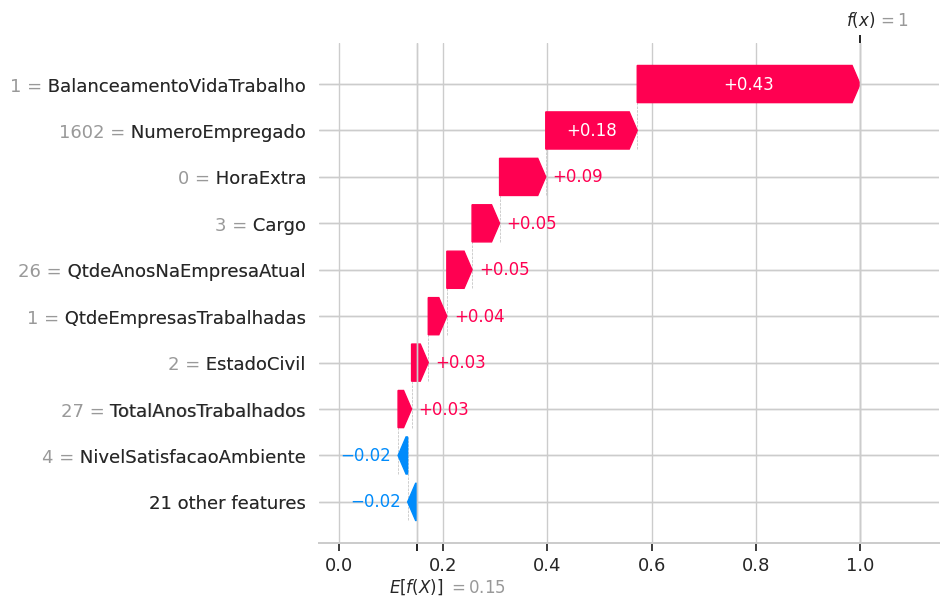

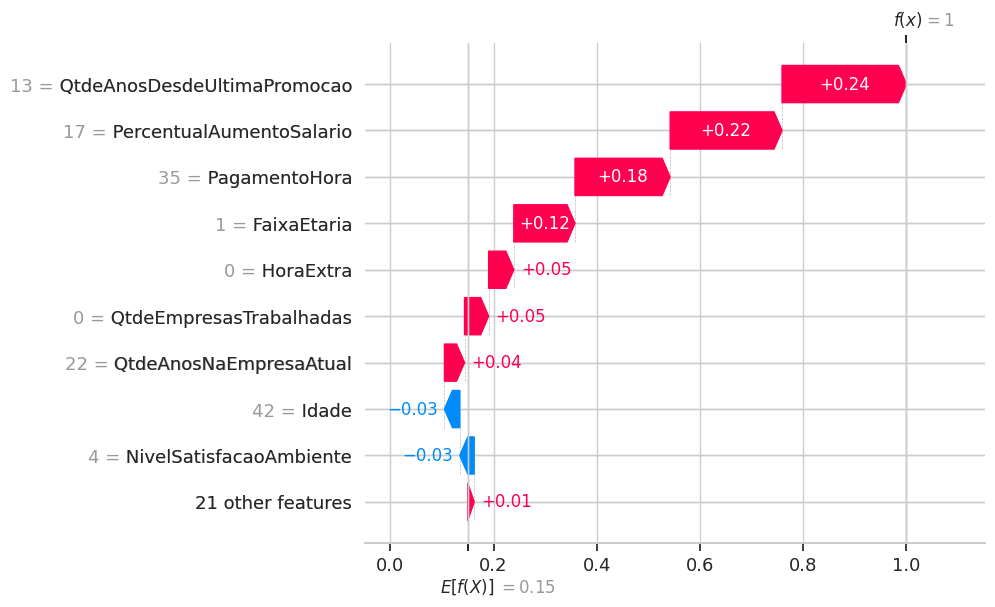

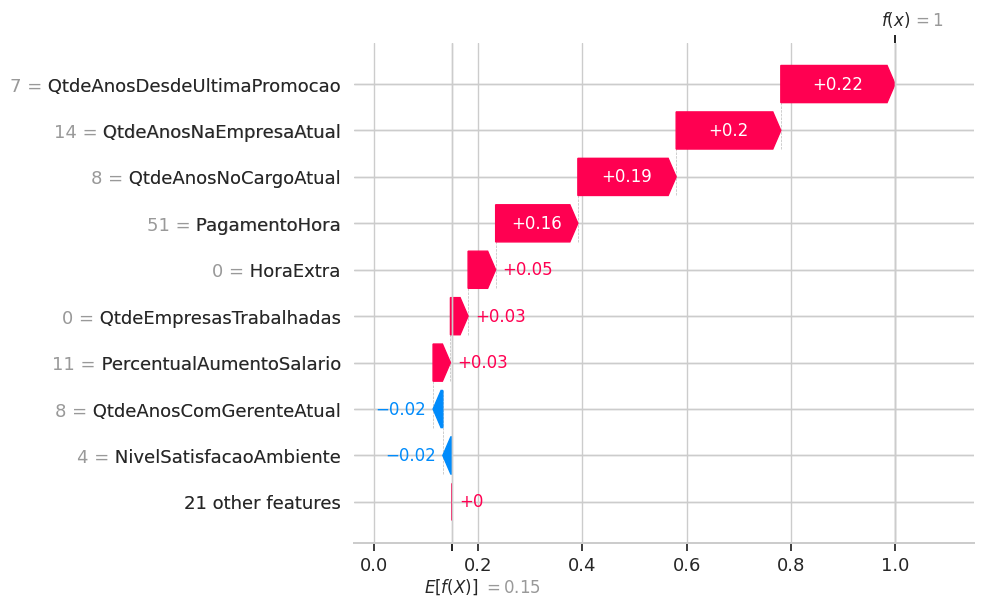

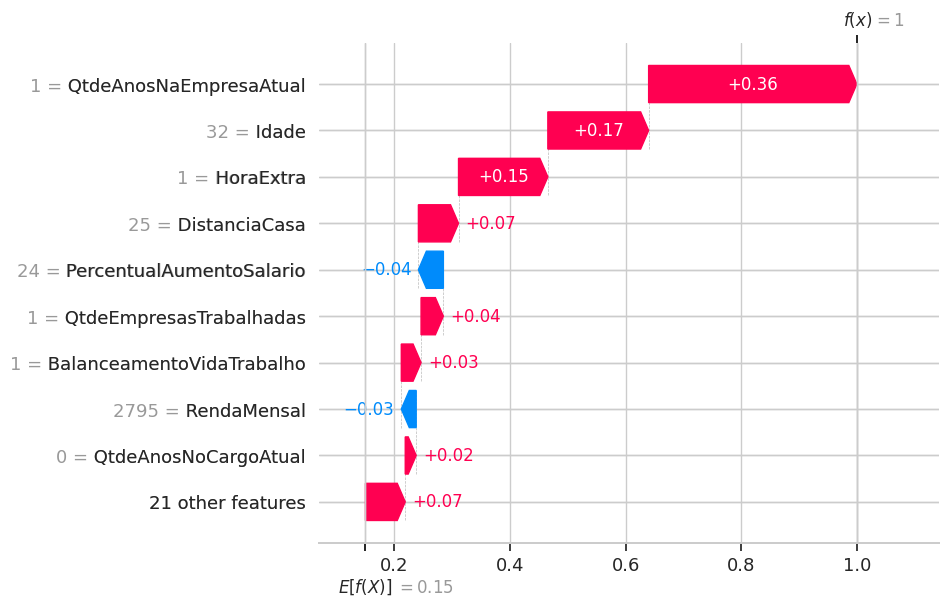

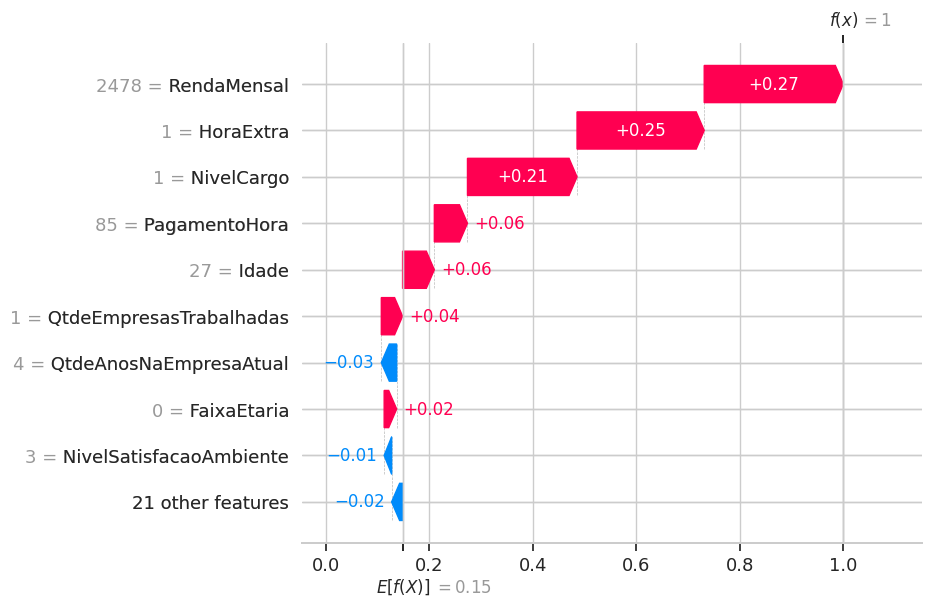

In [ ]:
# Converte os índices para posição
top5_indices = [X_test.index.get_loc(i) for i in top5["id"]]

# Apresentar explicações locais com waterfall para a classe "Saiu"
for idx in top5_indices:
    # Select SHAP values for the specific sample (idx) and the "Saiu" class (index 1)
    shap.plots.waterfall(shap_values[idx, :, 1])

## 🔍 Análise SHAP: Funcionários com Maior Risco de Sair

Após treinar um modelo de árvore de decisão balanceado, aplicamos SHAP para interpretar os motivos pelos quais o modelo prevê que determinados colaboradores têm alta probabilidade de deixar a empresa.

### 📌 O que é SHAP?

SHAP (SHapley Additive exPlanations) é uma técnica baseada na teoria dos jogos que explica as decisões de modelos de machine learning, mostrando o **impacto de cada variável** para uma predição individual.

---

### 🎯 Funcionários com Maior Probabilidade de Turnover

Selecionamos os 5 funcionários do conjunto de teste com maior `prob_sair` (probabilidade predita de saída). Cada um foi analisado com um gráfico `waterfall`, revelando os principais fatores que influenciaram a predição de saída (classe 1).

---

### 📈 Interpretação dos Gráficos

Cada gráfico mostra:

- **Fatores que aumentam o risco de saída** (em vermelho)
- **Fatores que reduzem o risco** (em azul)
- A soma dos efeitos resulta na **probabilidade final prevista**

---

### 🔍 Principais padrões observados:

- **Balanceamento Vida-Trabalho baixo**, **muitos anos na empresa atual**, e **alta carga horária** aparecem como fatores críticos.
- Variáveis como **Número de Treinamentos**, **Distância até o trabalho** e **Promoções recentes** também influenciaram negativamente.
- Em alguns casos, o modelo reconhece o tempo excessivo sem promoções ou altos salários com risco maior de saída.

---

### 💡 Como usar esses insights?

- Avaliar programas de retenção personalizados para funcionários com esses perfis.
- Monitorar sinais de alerta como queda na satisfação ou excesso de tempo sem promoção.
- Usar essa explicação como base para RH agir de forma proativa.

---

🧠 **Conclusão:**  
A explicabilidade por SHAP nos permite não apenas prever o turnover, mas entender **por que** ele está prestes a acontecer — dando ao time de gestão uma poderosa ferramenta para retenção e tomada de decisão baseada em dados.


In [ ]:
Ebn machine